# Notebook for regridding using xarray

### Read in geometry and apply coarsen to WRF lats/lons:

In [1]:
import xarray as xr

geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc") #Open WRF lat/lon coords file

coarse_geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean() #Find mean lat/lon of grid runs: averaging over 20 pixels is
                                                                                                    #roughly equivalent to 75 km (20 * 3.75 km = 75)

### New dimensions of lat/lon data are now 44 x 69 after averaging across 20 pixels (mean lat/lon of the 20th pixel run, or centroid)

## Create sample data to validate that this method upscales original data to ~75 x 75 km grid

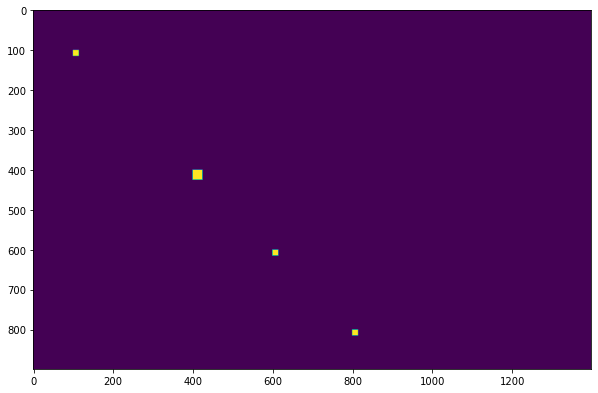

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 10

#this is simply the fastest way to make fake data and test this.. none of this is overly important
rand_eg = np.zeros(shape=(899, 1399))

rand_eg[400:425, 400:425] = 1
rand_eg[100:115, 100:115] = 1
rand_eg[600:615, 600:615] = 1
rand_eg[600:615, 600:615] = 1
rand_eg[800:815, 800:815] = 1

geog_test = deepcopy(geog[['CLAT', 'CLONG']])

geog_test['rand_eg'] = (('Time', 'south_north', 'west_east'), np.array([rand_eg]))

plt.imshow(geog_test['rand_eg'].values[0,:,:])

# Replicate above process using WRF hail day data

## Use open_mfdataset to open all intermediate daily max hail files

### NOTE: Must use 'combine' and 'concat_dim' parameters since 'Time' dimension is erased in each daily file (Time = 1)

In [2]:
test_year_hail_days = xr.open_mfdataset('/home/scratch/jgoodin/intermediate_hail_days/year_2000_daily_max/*.nc', combine = 'nested', concat_dim = 'Time')

In [3]:
test_year_hail_days #Print dataset, should return daily data

<xarray.Dataset>
Dimensions:     (Time: 366, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 899, 1399), meta=np.ndarray>

### Read in WRF HIST convective daily max .nc file- do this only for one test hail day, not for open_mfdataset

In [ ]:
daily_max_hail = xr.open_dataset("/home/scratch/jgoodin/convective_daily_max_resamples/hist_daily_max_hail_inches.nc")

daily_max_hail #Resampled to daily max (12z - 12z) HAIL_MAX2D size for each day and grid cell

### Use year 2000 as test year

In [ ]:
year_test = daily_max_hail.sel(Time = '2000')
year_test

## Pass severe hail threshold

In [4]:
sev_hail_days = 1 * (test_year_hail_days >= 0.0254) #Pass day threshold to this variable
sev_hail_days

<xarray.Dataset>
Dimensions:     (Time: 366, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 dask.array<chunksize=(1, 899, 1399), meta=np.ndarray>

In [5]:
print(type(sev_hail_days.sel(Time = '2000-04-20T12').HAIL_MAX2D))

<class 'xarray.core.dataarray.DataArray'>


### Select HAIL_MAX2D variable

In [6]:
sev_hail_days_var = sev_hail_days.HAIL_MAX2D
sev_hail_days_var

<xarray.DataArray 'HAIL_MAX2D' (Time: 366, south_north: 899, west_east: 1399)>
dask.array<mul, shape=(366, 899, 1399), dtype=int64, chunksize=(1, 899, 1399), chunktype=numpy.ndarray>
Coordinates:
  * Time     (Time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
Dimensions without coordinates: south_north, west_east

In [7]:
sev_hail_days_var.sel(Time = '2000-12-31T12')

<xarray.DataArray 'HAIL_MAX2D' (south_north: 899, west_east: 1399)>
dask.array<getitem, shape=(899, 1399), dtype=int64, chunksize=(899, 1399), chunktype=numpy.ndarray>
Coordinates:
    Time     datetime64[ns] 2000-12-31T12:00:00
Dimensions without coordinates: south_north, west_east

## Test plot one day that we know had hail to new grid- do this only for one test hail day, not for open_mfdataset

#### Select HAIL_MAX2D variable to create plottable numpy array- do this only for one test hail day, not for open_mfdataset

In [10]:
#test_day_var = test_day.HAIL_MAX2D

In [11]:
#print(type(test_day_var))

# Plot single hail day data to new grid

### Use for loop for open_mfdataset of intermediate daily max hail files

### Sum along time dimension and take mean to find mean annual hail day counts

In [19]:
annual_sum = sev_hail_days.sum(dim = 'Time')
annual_sum = annual_sum.HAIL_MAX2D
annual_sum

<xarray.DataArray 'HAIL_MAX2D' (south_north: 899, west_east: 1399)>
dask.array<sum-aggregate, shape=(899, 1399), dtype=int64, chunksize=(899, 1399), chunktype=numpy.ndarray>
Dimensions without coordinates: south_north, west_east

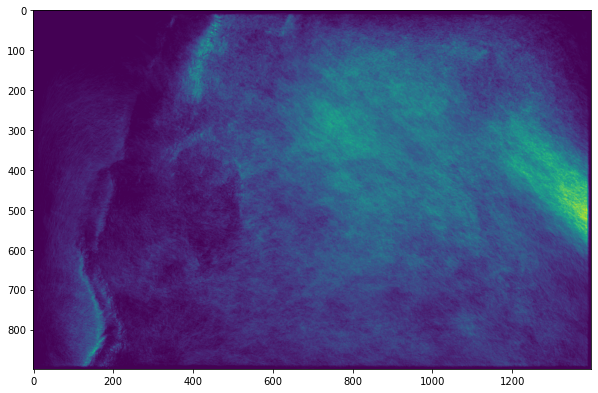

In [20]:
plt.rcParams['figure.figsize'] = 10, 10

"""
for dtime in sev_hail_days_var.Time:
    a = sev_hail_days_var.sel(Time = dtime)    
    #print(type(a))
    #annual_sum = a.sum()
    geog_test_hail = deepcopy(geog[['CLAT', 'CLONG']])
    geog_test_hail['a'] = (('Time', 'south_north', 'west_east'), np.array([a]))
a
"""

geog_test_hail = deepcopy(geog[['CLAT', 'CLONG']])

geog_test_hail['annual_sum'] = (('Time', 'south_north', 'west_east'), np.array([annual_sum]))

plt.imshow(geog_test_hail['annual_sum'].values[0,:,:])

# Coarsen the data

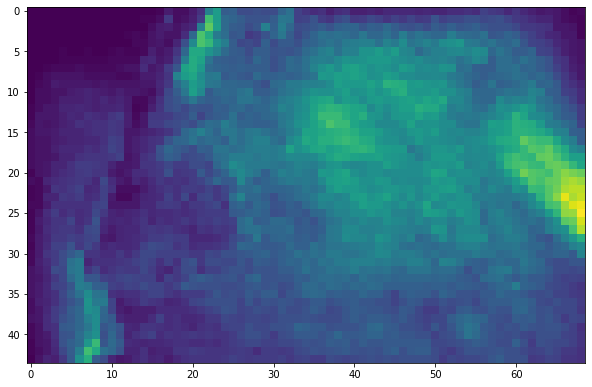

In [21]:
coarse_geog_test = geog_test_hail[['annual_sum']].coarsen(south_north=20, west_east=20, boundary='trim').max()

plt.imshow(coarse_geog_test['annual_sum'].values[0,:,:])

## To see if geometry lines up, plot coarsened grid over top of regular grid using transparency (alpha):

### New grid is outlined in white (approx. 75 x 75 km)

In [ ]:
import cartopy
import cartopy.crs as ccrs

"""
plt.rcParams['figure.figsize'] = 20, 20

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -70, 20, 50])
ax.coastlines()

ax.pcolormesh(geog['CLONG'].values[0,:,:], geog['CLAT'].values[0,:,:], test_day_var, 
              shading='nearest', transform=ccrs.PlateCarree())

ax.pcolormesh(coarse_geog['CLONG'].values[0,:,:], coarse_geog['CLAT'].values[0,:,:], coarse_geog_test['test_day_var'].values[0,:,:], 
              shading='nearest', transform=ccrs.PlateCarree(), cmap='Greys', alpha=0.5)
"""


/tmp/ipykernel_34447/3962195671.py:45: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_over('lemonchiffon')
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


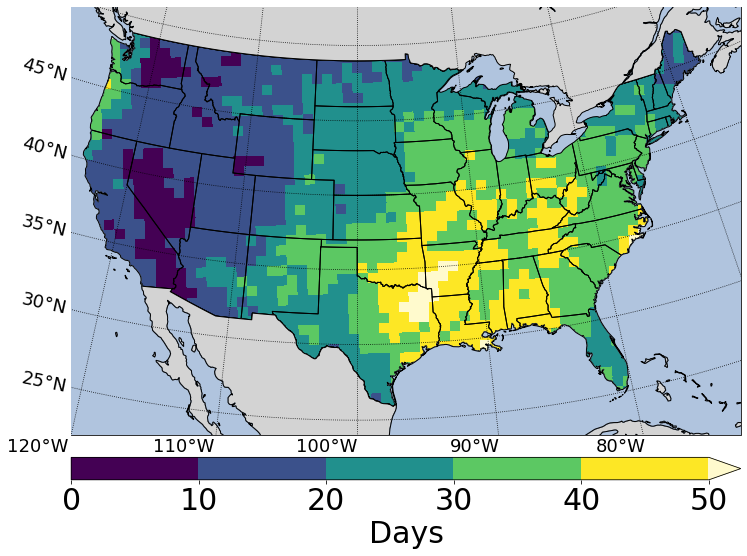

In [77]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize= (12,8)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
ax.set_extent([240,287,22,50])
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)

#lrFig = ax.pcolormesh(geog['CLONG'].values[0,:,:], geog['CLAT'].values[0,:,:], annual_sum, 
              #shading='nearest', transform=ccrs.PlateCarree(), vmax = 50)

cmap = cm.get_cmap('viridis')
cmap.set_over('lemonchiffon')
levels = np.arange(0, 60, 10)

mmp = ax.pcolormesh(coarse_geog['CLONG'].values[0,:,:], coarse_geog['CLAT'].values[0,:,:], coarse_geog_test['annual_sum'].values[0,:,:], 
              shading='nearest', transform=ccrs.PlateCarree(), cmap=cmap, vmin=levels[1], norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, 
                                                                                                                                    clip=False)) #alpha=0.5)

gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
gls.top_labels=False
gls.right_labels=False
gls.xlabel_style = {'size': 18, 'rotation': 0}
gls.xpadding = 12.0
gls.ylabel_style = {'size': 18}
ax2 = plt.subplot(gs1[1, 0]) 
#bounds = [0, 10, 20, 30, 40, 50]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = plt.colorbar(mmp, cax = ax2, ticks = [0, 10, 20, 30, 40, 50], orientation = 'horizontal', extend = 'max')
cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 30)
plt.subplots_adjust(bottom=0.12)